In [188]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
import numpy as np
from src.helpers import *
from scipy.stats import normaltest

In [412]:
#load dataset
movie_characters_ethnicity_df = pd.read_csv('generated/movie_characters_ethnicity.csv')
df_TMDB = pd.read_csv("generated/TMDB_extra_info.csv")
movie_characters_df = pd.read_csv('generated/movie_characters.csv')
movie_characters_ethnicity_df = pd.read_csv('generated/movie_characters_ethnicity.csv')

In [413]:
#prepare dataset
df_TMDB.rename(columns={'title': 'movie_name'}, inplace=True)
performance_df = movie_characters_ethnicity_df.merge(df_TMDB, on='movie_name', how='inner')
performance_df.dropna(subset=['movie_box_office_revenue'], inplace=True)
performance_df.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id','character_actor_freebase_map_id',
                                   'character_name','movie_wikipedia_id', 'movie_freebase_id','actor_name','actor_gender',
                                   'actor_ethnicity','actor_age_at_movie_release'], inplace=True)

In [415]:
#create the diverse dataset
# age
age_diversity = movie_characters_df.groupby('movie_name')['actor_age_at_movie_release'].std()
diverse_age_movies_over_10 = age_diversity[age_diversity > 10].index

#sex
movie_characters_df['is_female'] = movie_characters_df['actor_gender'] == 'F'
gender_proportion_by_movie = movie_characters_df.groupby('movie_name')['is_female'].mean()
percent_female_by_movie = gender_proportion_by_movie * 100
diversified_gender_movies = percent_female_by_movie[(percent_female_by_movie >= 30) & (percent_female_by_movie <= 70)]

#ethnicity
ethnicity_counts = movie_characters_ethnicity_df.groupby('movie_name')['actor_ethnicity'].nunique()
diversified_movies_ethnicity = ethnicity_counts[ethnicity_counts >= 4]

In [416]:
#conditions for diversity
conditions = (performance_df['movie_name'].isin(diversified_movies_ethnicity.index) &
    performance_df['movie_name'].isin(diversified_gender_movies.index) &
    performance_df['movie_name'].isin(diverse_age_movies_over_10))

#create the diverse dataset 1 diverse 0 not diverse
performance_df['diverse'] = np.where(conditions, 1, 0)

#keep only 1 appearance of each movie
performance_df.drop_duplicates(['movie_name'], keep='first', inplace=True)

#extract the diverse and not diverse dataset
diverse_movie = performance_df[performance_df['diverse'] == 1]
not_divers_movie = performance_df[performance_df['diverse'] == 0]
print('diverse',diverse_movie.shape)
print('not_diverse',not_divers_movie.shape)

diverse (1089, 8)
not_diverse (4581, 8)


Text(0.5, 1.0, 'Distribution of movies release year')

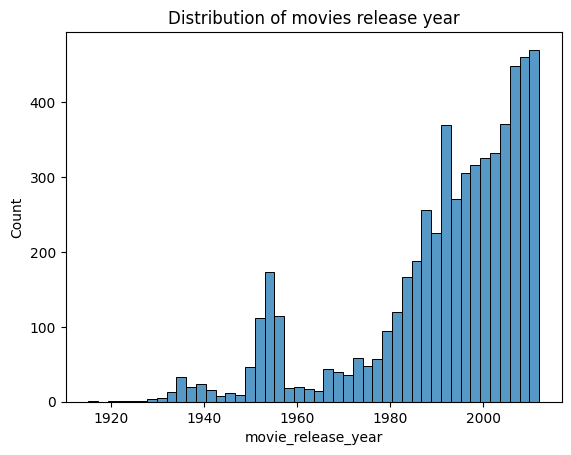

In [437]:
sns.histplot(performance_df['movie_release_year'])
plt.title('Distribution of movies release year')

Text(0.5, 1.0, 'Cumulative Distribution of movies release year')

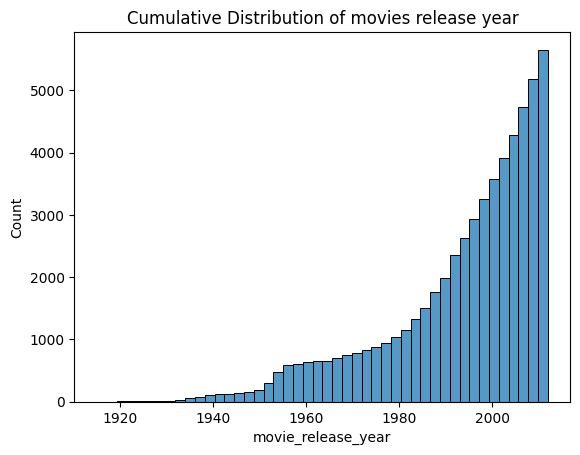

In [438]:
sns.histplot(performance_df['movie_release_year'], cumulative=True)
plt.title('Cumulative Distribution of movies release year')

In [456]:
#compute the year range of the 10 parts with an equivalent number of movies in each part
total_size = performance_df.shape[0]
number_parts = 10
share = total_size/(number_parts+1)
cumulative_data = performance_df['movie_release_year'].value_counts().sort_index().cumsum()
cutoff = []
for i in range(number_parts+1):
    cutoff.append(cumulative_data[cumulative_data > i*share].index[0])

for i in range(len(cutoff)):
    if i < len(cutoff)-1:
        print(i+1,'part:', int(cutoff[i]),'-', int(cutoff[i+1]))

1 part: 1915 - 1956
2 part: 1956 - 1980
3 part: 1980 - 1987
4 part: 1987 - 1991
5 part: 1991 - 1995
6 part: 1995 - 1998
7 part: 1998 - 2002
8 part: 2002 - 2005
9 part: 2005 - 2007
10 part: 2007 - 2009


In [420]:
#knowing the 10 parts create a dictionary with the dataframe of each part
period_dataframes = {}
for i in range(len(cutoff)):
    if i == 0:
        pass
    else:
        period_df = performance_df[
            (performance_df['movie_release_year'] > cutoff[i - 1]) &
            (performance_df['movie_release_year'] <= cutoff[i])
        ]
    if i != 0:
        period_dataframes[f'df_period{i}'] = period_df

In [464]:
#compute the percentage of diverse movies in each part
percentage_diverse_movies = []
for i in range(1,11):
    period_name = f'df_period{i}'
    percentage_diverse_movies.append(period_dataframes[period_name]['diverse'].apply(lambda x: x==1).sum()/period_dataframes['df_period1'].shape[0]*100)

Text(0, 0.5, 'Percentage of diverse movies')

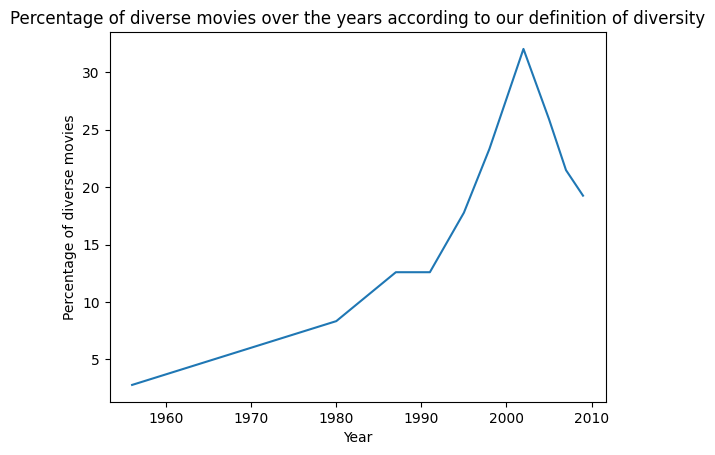

In [471]:
plt.plot(cutoff[1:], percentage_diverse_movies)
plt.title('Percentage of diverse movies over the years according to our definition of diversity')
plt.xlabel('Year')
plt.ylabel('Percentage of diverse movies')

In [421]:
def standardize_continuous_features(df):
    df['movie_release_year'] = (df['movie_release_year'] - df['movie_release_year'].mean()) / df['movie_release_year'].std()
    df['movie_box_office_revenue'] = (df['movie_box_office_revenue'] - df['movie_box_office_revenue'].mean()) / df['movie_box_office_revenue'].std()
    df['budget'] = (df['budget'] - df['budget'].mean()) / df['budget'].std()
    return df

def add_propensity_score(df):
    df = standardize_continuous_features(df)
    mod = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

In [422]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [423]:
def compute_balance_df(df): 
    # Separate the treatment and control groups
    treatment_df = df[df['diverse'] == 1]
    control_df = df[df['diverse'] == 0]
    print("treatment size:",treatment_df.shape[0])
    print("control size:",control_df.shape[0])

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df


In [425]:
df1 = add_propensity_score(period_dataframes['df_period1'])
df2 = add_propensity_score(period_dataframes['df_period2'])
df3= add_propensity_score(period_dataframes['df_period3'])
df4 = add_propensity_score(period_dataframes['df_period4'])
df5 = add_propensity_score(period_dataframes['df_period5'])
df6 = add_propensity_score(period_dataframes['df_period6'])
df7 = add_propensity_score(period_dataframes['df_period7'])
df8 = add_propensity_score(period_dataframes['df_period8'])
df9 = add_propensity_score(period_dataframes['df_period9'])
df10 = add_propensity_score(period_dataframes['df_period10'])
balanced_df1 = compute_balance_df(df1)
balanced_df2 = compute_balance_df(df2)
balanced_df3 = compute_balance_df(df3)
balanced_df4 = compute_balance_df(df4)
balanced_df5 = compute_balance_df(df5)
balanced_df6 = compute_balance_df(df6)
balanced_df7 = compute_balance_df(df7)
balanced_df8 = compute_balance_df(df8)
balanced_df9 = compute_balance_df(df9)
balanced_df10 = compute_balance_df(df10)


C:\Users\Louis\AppData\Local\Temp\ipykernel_38136\1976874260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['movie_release_year'] = (df['movie_release_year'] - df['movie_release_year'].mean()) / df['movie_release_year'].std()
C:\Users\Louis\AppData\Local\Temp\ipykernel_38136\1976874260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['movie_box_office_revenue'] = (df['movie_box_office_revenue'] - df['movie_box_office_revenue'].mean()) / df['movie_box_office_revenue'].std()
C:\Users\Louis\AppDa

Optimization terminated successfully.
         Current function value: 0.119957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.580561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557543
         Iterations 5


C:\Users\Louis\AppData\Local\Temp\ipykernel_38136\1976874260.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Propensity_score'] = res.predict()
C:\Users\Louis\AppData\Local\Temp\ipykernel_38136\1976874260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['movie_release_year'] = (df['movie_release_year'] - df['movie_release_year'].mean()) / df['movie_release_year'].std()
C:\Users\Louis\AppData\Local\Temp\ipykernel_38136\1976874260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

Optimization terminated successfully.
         Current function value: 0.530147
         Iterations 5
treatment size: 15
control size: 525
treatment size: 45
control size: 449
treatment size: 68
control size: 532
treatment size: 68
control size: 392
treatment size: 96
control size: 438
treatment size: 126
control size: 341
treatment size: 173
control size: 477
treatment size: 140
control size: 392
treatment size: 116
control size: 332
treatment size: 104
control size: 356


In [439]:
#save the entire balanced dataset
all_balanced_df = pd.concat([balanced_df1,balanced_df2,balanced_df3,balanced_df4,balanced_df5,balanced_df6,balanced_df7,balanced_df8,balanced_df9,balanced_df10], ignore_index=False)
all_balanced_df.to_csv('generated/balanced_df_4ethn__30_70sex__10age.csv')

### Logistic regression on for the 10 balanced dataframes

In [441]:
mod1 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df1)
mod2 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df2)
mod3 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df3)
mod4 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df4)
mod5 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df5)
mod6 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df6)
mod7 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df7)
mod8 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df8)
mod9 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df9)
mod10 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=balanced_df10)
modall = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=all_balanced_df)

print(mod1.fit().summary())

Optimization terminated successfully.
         Current function value: 0.648230
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                   30
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.06480
Time:                        15:44:28   Log-Likelihood:                -19.447
converged:                       True   LL-Null:                       -20.794
Covariance Type:            nonrobust   LLR p-value:                    0.4411
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.1531      4.336      0.497      0.620      -6.346

In [428]:
print(mod2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.690739
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                   90
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.003475
Time:                        15:33:25   Log-Likelihood:                -62.166
converged:                       True   LL-Null:                       -62.383
Covariance Type:            nonrobust   LLR p-value:                    0.9332
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.3462      0.816     -0.424      0.671      -1.946

In [429]:
print(mod3.fit().summary())

Optimization terminated successfully.
         Current function value: 0.690311
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  136
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.004092
Time:                        15:33:27   Log-Likelihood:                -93.882
converged:                       True   LL-Null:                       -94.268
Covariance Type:            nonrobust   LLR p-value:                    0.8563
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0801      0.966     -0.083      0.934      -1.973

In [430]:
print(mod4.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691137
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  136
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.002900
Time:                        15:33:31   Log-Likelihood:                -93.995
converged:                       True   LL-Null:                       -94.268
Covariance Type:            nonrobust   LLR p-value:                    0.9085
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.0175      1.466      0.694      0.488      -1.856

In [431]:
print(mod5.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691307
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  192
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.002654
Time:                        15:33:32   Log-Likelihood:                -132.73
converged:                       True   LL-Null:                       -133.08
Covariance Type:            nonrobust   LLR p-value:                    0.8717
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.5642      0.716     -0.788      0.431      -1.968

In [432]:
print(mod6.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691866
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  252
Model:                          Logit   Df Residuals:                      248
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.001849
Time:                        15:33:34   Log-Likelihood:                -174.35
converged:                       True   LL-Null:                       -174.67
Covariance Type:            nonrobust   LLR p-value:                    0.8859
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.4627      0.625     -0.741      0.459      -1.687

In [433]:
print(mod7.fit().summary())

Optimization terminated successfully.
         Current function value: 0.691666
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  346
Model:                          Logit   Df Residuals:                      342
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.002136
Time:                        15:33:35   Log-Likelihood:                -239.32
converged:                       True   LL-Null:                       -239.83
Covariance Type:            nonrobust   LLR p-value:                    0.7953
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0019      0.649     -0.003      0.998      -1.274

In [434]:
print(mod8.fit().summary())

Optimization terminated successfully.
         Current function value: 0.689612
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  280
Model:                          Logit   Df Residuals:                      276
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.005100
Time:                        15:33:36   Log-Likelihood:                -193.09
converged:                       True   LL-Null:                       -194.08
Covariance Type:            nonrobust   LLR p-value:                    0.5766
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.7970      0.737     -1.081      0.279      -2.241

In [435]:
print(mod9.fit().summary())

Optimization terminated successfully.
         Current function value: 0.690789
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  232
Model:                          Logit   Df Residuals:                      228
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.003403
Time:                        15:33:38   Log-Likelihood:                -160.26
converged:                       True   LL-Null:                       -160.81
Covariance Type:            nonrobust   LLR p-value:                    0.7784
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.8686      0.915      0.950      0.342      -0.924

In [436]:
print(mod10.fit().summary())

Optimization terminated successfully.
         Current function value: 0.687176
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  208
Model:                          Logit   Df Residuals:                      204
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.008615
Time:                        15:33:39   Log-Likelihood:                -142.93
converged:                       True   LL-Null:                       -144.17
Covariance Type:            nonrobust   LLR p-value:                    0.4782
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.6984      0.667     -1.047      0.295      -2.006

In [443]:
print(modall.fit().summary())

Optimization terminated successfully.
         Current function value: 0.692663
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                 1902
Model:                          Logit   Df Residuals:                     1898
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:               0.0006982
Time:                        15:44:50   Log-Likelihood:                -1317.4
converged:                       True   LL-Null:                       -1318.4
Covariance Type:            nonrobust   LLR p-value:                    0.6060
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.2901      0.250     -1.162      0.245      -0.779

In [472]:
#check results with the non balanced dataframe just to have an idea, will be deleted later
mod1 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df1)
mod2 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df2)
mod3 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df3)
mod4 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df4)
mod5 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df5)
mod6 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df6)
mod7 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df7)
mod8 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df8)
mod9 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df9)
mod10 = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=df10)


In [473]:
print(mod1.fit().summary())

Optimization terminated successfully.
         Current function value: 0.119957
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  540
Model:                          Logit   Df Residuals:                      536
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.05494
Time:                        16:21:59   Log-Likelihood:                -64.777
converged:                       True   LL-Null:                       -68.542
Covariance Type:            nonrobust   LLR p-value:                   0.05676
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -9.3104      2.423     -3.842      0.000     -14.060

In [474]:
print(mod2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.286535
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  494
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.06072
Time:                        16:22:10   Log-Likelihood:                -141.55
converged:                       True   LL-Null:                       -150.70
Covariance Type:            nonrobust   LLR p-value:                 0.0003810
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.9163      0.740     -1.239      0.215      -2.366

In [475]:
print(mod3.fit().summary())

Optimization terminated successfully.
         Current function value: 0.342255
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  600
Model:                          Logit   Df Residuals:                      596
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.03161
Time:                        16:22:20   Log-Likelihood:                -205.35
converged:                       True   LL-Null:                       -212.06
Covariance Type:            nonrobust   LLR p-value:                  0.003832
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.8776      0.764     -2.458      0.014      -3.375

In [476]:
print(mod4.fit().summary())

Optimization terminated successfully.
         Current function value: 0.409729
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  460
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.02194
Time:                        16:22:26   Log-Likelihood:                -188.48
converged:                       True   LL-Null:                       -192.70
Covariance Type:            nonrobust   LLR p-value:                   0.03747
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3455      0.942     -2.490      0.013      -4.191

In [477]:
print(mod5.fit().summary())

Optimization terminated successfully.
         Current function value: 0.459557
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  534
Model:                          Logit   Df Residuals:                      530
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.02440
Time:                        16:22:33   Log-Likelihood:                -245.40
converged:                       True   LL-Null:                       -251.54
Covariance Type:            nonrobust   LLR p-value:                  0.006490
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0676      0.566     -1.887      0.059      -2.176

In [478]:
print(mod6.fit().summary())

Optimization terminated successfully.
         Current function value: 0.580561
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  467
Model:                          Logit   Df Residuals:                      463
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.004298
Time:                        16:22:39   Log-Likelihood:                -271.12
converged:                       True   LL-Null:                       -272.29
Covariance Type:            nonrobust   LLR p-value:                    0.5048
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.1555      0.595     -1.942      0.052      -2.322

In [479]:
print(mod7.fit().summary())

Optimization terminated successfully.
         Current function value: 0.577162
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  650
Model:                          Logit   Df Residuals:                      646
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.003855
Time:                        16:22:52   Log-Likelihood:                -375.16
converged:                       True   LL-Null:                       -376.61
Covariance Type:            nonrobust   LLR p-value:                    0.4067
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0645      0.506     -2.104      0.035      -2.056

In [480]:
print(mod8.fit().summary())

Optimization terminated successfully.
         Current function value: 0.573077
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  532
Model:                          Logit   Df Residuals:                      528
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.005651
Time:                        16:23:01   Log-Likelihood:                -304.88
converged:                       True   LL-Null:                       -306.61
Covariance Type:            nonrobust   LLR p-value:                    0.3253
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8588      0.645     -1.332      0.183      -2.123

In [481]:
print(mod9.fit().summary())

Optimization terminated successfully.
         Current function value: 0.557543
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  448
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                 0.02516
Time:                        16:23:09   Log-Likelihood:                -249.78
converged:                       True   LL-Null:                       -256.23
Covariance Type:            nonrobust   LLR p-value:                  0.004873
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.9236      0.684     -1.351      0.177      -2.264

In [482]:
print(mod10.fit().summary())    

Optimization terminated successfully.
         Current function value: 0.530147
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                diverse   No. Observations:                  460
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                0.008152
Time:                        16:23:21   Log-Likelihood:                -243.87
converged:                       True   LL-Null:                       -245.87
Covariance Type:            nonrobust   LLR p-value:                    0.2605
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.6440      0.605     -1.064      0.287      -1.831